In [15]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as pltn
import random
import copy
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
seed_value=46

In [16]:
%run "C:\Users\nharr\Downloads\CS 333 Technical Demo.ipynb"

In [17]:
# Create a graph with 15 nodes and no edges
test_graph = nx.Graph()
test_graph.add_nodes_from(range(1,16))

# Manually add edges to the graph
edges_to_add = [(1, 2), (1, 3), (3, 4), (2, 4), (2, 5), (4, 5), (4, 6), (3, 6), (5, 12), (5, 13),  # Example edges
                (5, 7), (6, 7), (6, 8),(7,9), (8, 9),(9,10),(7,11), (7,12),
                (10, 11), (11, 12), (12, 13), (13, 14),(13,15),(11,15)
                ]  # Connecting the subgraphs

test_graph.add_edges_from(edges_to_add)

<class 'list'>


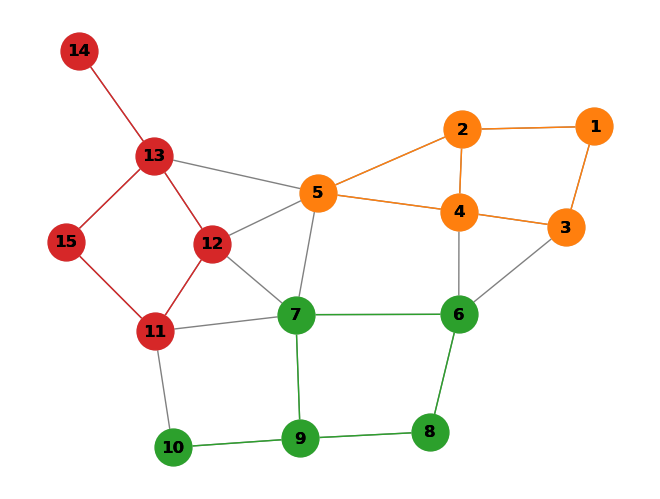

In [18]:
# Example usage:
# Divide the existing graph into 3 subgraphs
testsubgraphs = divide_into_subgraphs(test_graph, 3)
print(type(testsubgraphs))

# Visualize the original graph and the subgraphs
visualize_subgraphs(test_graph, testsubgraphs)

In [120]:
# Give nodes test population
for node in test_graph.nodes:
    test_graph.nodes[node]['population'] = random.randint(40, 60)

# Modify the populations to make the total population of each subgraph different
for subgraph in testsubgraphs:
    subgraph_population = sum(test_graph.nodes[node]['population'] for node in subgraph)
    scaling_factor = random.uniform(0.5, 2.0)  # Adjust this range based on your preferences
    for node in subgraph:
        test_graph.nodes[node]['population'] = int(test_graph.nodes[node]['population'] * scaling_factor)

# Print the population of Node 10 (assuming you meant Node 10 instead of Node 7)
print("Population of Node 10:", test_graph.nodes[10]['population'])

Population of Node 10: 28


In [123]:
# Assign random PVI to each node
for node in test_graph.nodes:
    test_graph.nodes[node]['PVI'] = random.randint(-15, 15)
print("PVI Node 7:", test_graph.nodes[7]['PVI'])

PVI Node 7: -6


Random conflicted edge: (5, 12)


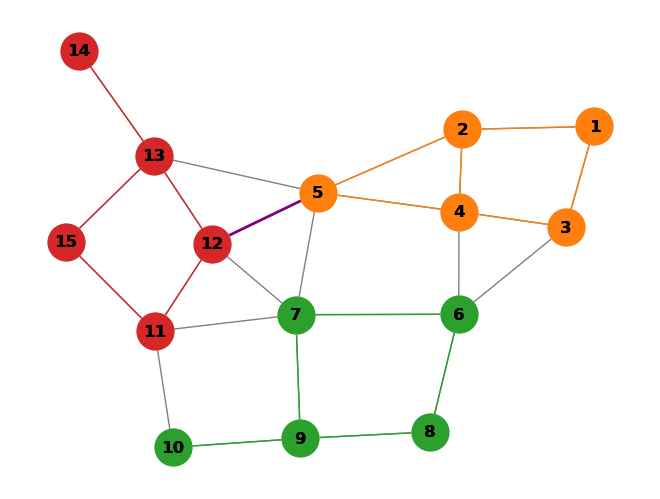

In [124]:
conflicted_edge = get_random_edge_between_subgraphs(test_graph,testsubgraphs)
print("Random conflicted edge:", conflicted_edge)
visualize_subgraphs(test_graph, testsubgraphs, conflicted_edge)

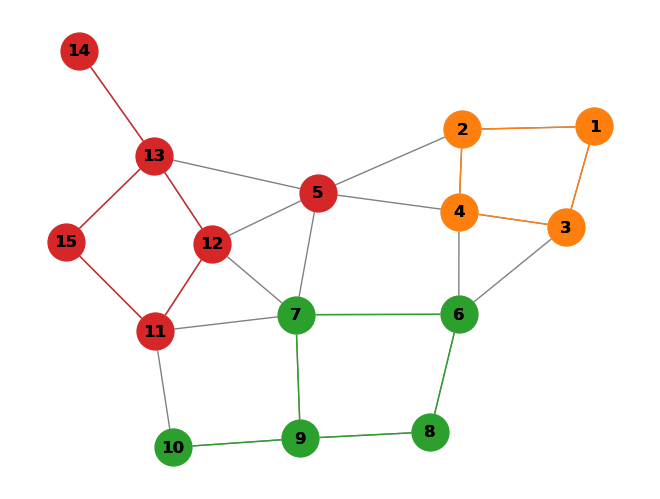

In [125]:
modified_graph, modified_subgraphs = create_proposed_state(test_graph, testsubgraphs, conflicted_edge)
visualize_subgraphs(modified_graph,modified_subgraphs)

In [126]:
total_population=calculate_total_population(test_graph)
print(total_population)

803


In [127]:
populationscore(test_graph,testsubgraphs)

907.34

In [129]:
def visualize_subgraphs2(graph, subgraphs, highlighted_edge="none"):
    pos = nx.spring_layout(graph, seed=seed_value)  # You can use a different layout if you prefer

    # Draw the original graph
    nx.draw(graph, pos, with_labels=True, font_weight='bold', node_color='lightgray', edge_color='gray', node_size=700)

    # Draw each subgraph with a different color
    for i, subgraph in enumerate(subgraphs, start=1):
        nx.draw(subgraph, pos, with_labels=True, font_weight='bold', node_color=f'C{i}', edge_color=f'C{i}', node_size=700)

    # Highlight the specified edge if it's not "none"
    if highlighted_edge != "none":
        nx.draw_networkx_edges(graph, pos, edgelist=[highlighted_edge], edge_color='purple', width=2)

In [130]:
c_pop=.03
def populationscore(graph,subgraphs):
    totalsum=0
    districtaverage=total_population/len(subgraphs)
    for i, subgraph in enumerate(subgraphs, start=1):
        # Calculate the sum of populations for each subgraph
        population_sum = sum(graph.nodes[node]['population'] for node in subgraph.nodes)
        totalsum+=(population_sum-districtaverage)**2
    return(c_pop*totalsum)

In [131]:
def PVIscore(graph,subgraphs):
    return 0

In [132]:
lambda_J=1
def totalscorefunction(graph,subgraph):
    return lambda_J*populationscore(graph,subgraph)+(1-lambda_J)*PVIscore(graph,subgraph)

In [133]:
def are_subgraphs_connected(graph, subgraphs):
    for subgraph in subgraphs:
        if not nx.is_connected(graph.subgraph(subgraph.nodes())):
            return False
    return True
print(are_subgraphs_connected(test_graph,testsubgraphs))

True


In [135]:
beta=0.01
import numpy as np

def one_iteration_of_MCMC_here(graph, subgraphs):
    con1 = len(get_edges_between_subgraphs(graph, subgraphs))
    conflicted_edge = get_random_edge_between_subgraphs(graph, subgraphs)
    
    while True:
        proposed_graph, proposed_subgraphs = create_proposed_state(graph, subgraphs, conflicted_edge)
        
        # Check if the proposed subgraph is connected
        if are_subgraphs_connected(proposed_graph, proposed_subgraphs):
            break  # Exit the loop if connected

        # If not connected, generate a different conflicted edge and try again
        conflicted_edge = get_random_edge_between_subgraphs(graph, subgraphs)

    con2 = len(get_edges_between_subgraphs(proposed_graph, proposed_subgraphs))
    probfromscorefunctions = np.exp(-1 * beta * (totalscorefunction(proposed_graph, proposed_subgraphs) - totalscorefunction(graph, subgraphs))) 
    transitionprobability = min(1, con1 / con2, probfromscorefunctions)

    # Generate a random number between 0 and 1
    random_number = np.random.rand()

    # Check if the random number is less than the transition probability
    if random_number < transitionprobability:
        return proposed_graph, proposed_subgraphs
    else:
        return graph, subgraphs


907.34
1428.1399999999999
[(3, 6), (4, 6), (5, 7), (12, 7), (5, 13), (12, 11), (12, 13), (7, 11), (10, 11)]


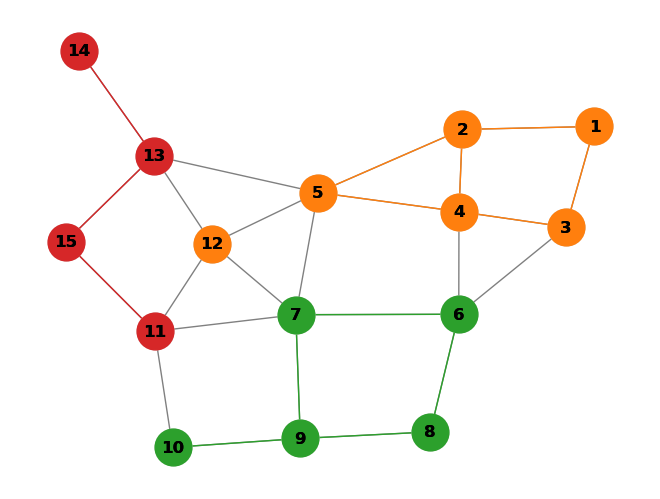

In [136]:
conflicted_edge = get_random_edge_between_subgraphs(test_graph, testsubgraphs)
print(populationscore(test_graph,testsubgraphs))
holder=create_proposed_state(test_graph,testsubgraphs,conflicted_edge)
visualize_subgraphs2(holder[0],holder[1])
print(populationscore(holder[0],holder[1]))
print(get_edges_between_subgraphs(holder[0],holder[1]))

<class 'list'>
Graph with 6 nodes and 3 edges
142.94
[(2, 5), (4, 5), (6, 7), (6, 8), (5, 12), (5, 13), (7, 12), (11, 12), (11, 15)]


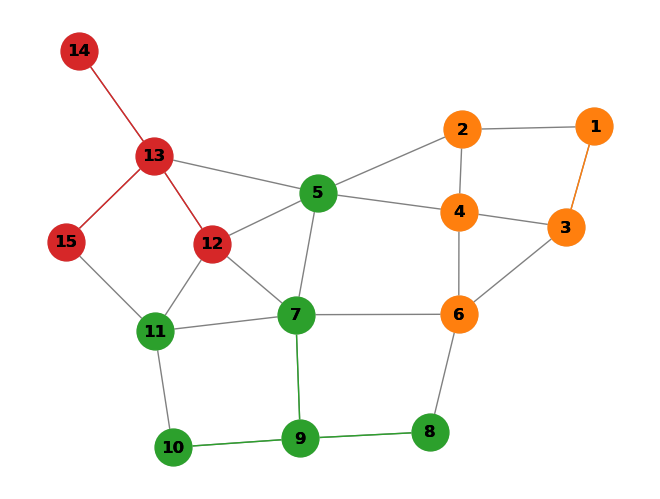

In [157]:
num_iterations=70
graph1=test_graph
subgraphs1=testsubgraphs
print(type(subgraphs1))
for _ in range(num_iterations):
        # Call one_iteration_of_MCMC for each iteration
        graph1,subgraphs1=one_iteration_of_MCMC_here(graph1,subgraphs1)
visualize_subgraphs2(graph1,subgraphs1)
print(subgraphs1[1])
print(populationscore(graph1,subgraphs1))
print(get_edges_between_subgraphs(graph1,subgraphs1))

In [188]:
beta=0.01
import numpy as np

def get_a_valid_conflicted_edge(graph, subgraphs):
    conflicted_edge = get_random_edge_between_subgraphs(graph, subgraphs)
    
    while True:
        proposed_graph, proposed_subgraphs = create_proposed_state(graph, subgraphs, conflicted_edge)
        
        # Check if the proposed subgraph is connected
        if are_subgraphs_connected(proposed_graph, proposed_subgraphs):
            return  proposed_graph, proposed_subgraphs, conflicted_edge # Exit the loop if connected

        # If not connected, generate a different conflicted edge and try again
        conflicted_edge = get_random_edge_between_subgraphs(graph, subgraphs)

def Modified_one_iteration_of_MCMC_here(graph,subgraphs,proposed_graph, proposed_subgraphs):
    con1 = len(get_edges_between_subgraphs(graph, subgraphs))
    con2 = len(get_edges_between_subgraphs(proposed_graph, proposed_subgraphs))
    probfromscorefunctions = np.exp(-1 * beta * (totalscorefunction(proposed_graph, proposed_subgraphs) - totalscorefunction(graph, subgraphs))) 
    transitionprobability = min(1, con1 / con2, probfromscorefunctions)

    # Generate a random number between 0 and 1
    random_number = np.random.rand()

    # Check if the random number is less than the transition probability
    if random_number < transitionprobability:
        return proposed_graph, proposed_subgraphs
    else:
        return graph, subgraphs

In [186]:
import os

In [189]:
# Set the frames directory
frames_directory = r"C:\Users\nharr\OneDrive\Documents\TestGraphCorrectMCMC"
os.makedirs(frames_directory, exist_ok=True)

# Rest of your code remains unchanged
num_iterations = 100
graph1 = test_graph
subgraphs1 = testsubgraphs

for iteration in range(num_iterations):
    proposed_graph, proposed_subgraphs, conflicted_edge = get_a_valid_conflicted_edge(graph1, subgraphs1)
    if not are_subgraphs_connected(proposed_graph, proposed_subgraphs):
        print("PROBLEM")
        break
    visualize_subgraphs2(graph1, subgraphs1, conflicted_edge)

    # Save the first frame
    frame_filename = f"frame_{iteration * 2}.png"
    frame_path = os.path.join(frames_directory, frame_filename)
    plt.savefig(frame_path, format='png')
    plt.clf()

    graph1, subgraphs1 = Modified_one_iteration_of_MCMC_here(graph1, subgraphs1, proposed_graph, proposed_subgraphs)
    visualize_subgraphs2(graph1, subgraphs1)

    # Save the second frame
    frame_filename = f"frame_{iteration * 2 + 1}.png"
    frame_path = os.path.join(frames_directory, frame_filename)
    plt.savefig(frame_path, format='png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [191]:
populationscore(graph1,subgraphs1)

47.17999999999999

In [192]:
pip install opencv-python

In [197]:
import cv2
import os

# Path to the directory containing PNG frames
frames_directory = r"C:\Users\nharr\OneDrive\Documents\TestGraphCorrectMCMC"

# Output video file name
output_video_filename = r"C:\Users\nharr\OneDrive\Documents\test_graph_population_corrected.mp4"

# List all frame files in the directory and sort them based on the numeric part of the file name
frame_files = sorted([f for f in os.listdir(frames_directory) if f.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))

# Read the first frame to get dimensions
first_frame = cv2.imread(os.path.join(frames_directory, frame_files[0]))
height, width, _ = first_frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use an appropriate codec (e.g., mp4v)
video_writer = cv2.VideoWriter(output_video_filename, fourcc, 1.5, (width, height))

# Write each frame to the video
for frame_file in frame_files:
    frame_path = os.path.join(frames_directory, frame_file)
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

# Release the VideoWriter
video_writer.release()


In [73]:
%run generate_data.py

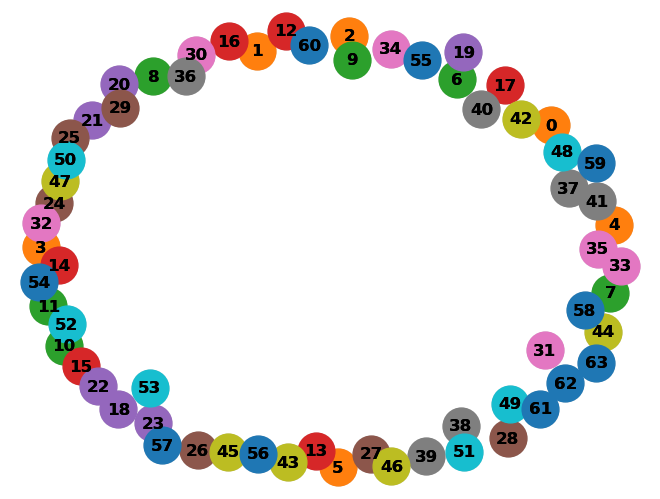

In [75]:
colorado_graph=get_colorado_graph("county.csv","data_by_county.csv")
colorado_districts=divide_into_subgraphs(colorado_graph,10)
visualize_subgraphs(colorado_graph,colorado_districts)